In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# set csv dir and get a sorted list of csv files
directory_path = './csvs'
# get a list of the csv file paths
file_paths = [] 
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.CSV'):
        # Construct the full file path
        file_paths.append(os.path.join(directory_path, filename))

# load one file into a dataframe and preview it
tmp_df = pd.read_csv(file_paths[0])
print('data sample:\n', tmp_df.head())
print('\ndtypes: ', tmp_df.dtypes)

data sample:
                   DATE  PM2.5  PM10  HCHO  TVOC  TEMP  HUMI UNIT
0  2023-07-23 11:57:05    0.9   1.5  0.02  0.09    26    55    C
1  2023-07-23 11:58:05    0.9   1.7  0.02  0.05    26    54    C
2  2023-07-23 11:59:05    0.9   1.4  0.02  0.08    26    54    C
3  2023-07-23 12:00:05    0.7   1.3  0.02  0.08    26    54    C
4  2023-07-23 12:01:05    0.8   1.3  0.02  0.09    26    54    C

dtypes:  DATE      object
PM2.5    float64
PM10     float64
HCHO     float64
TVOC     float64
TEMP       int64
HUMI       int64
UNIT      object
dtype: object


In [2]:
# function to clean up the dataframe and do necessary changes
def clean_df(df):
    # set date column to be index
    df.set_index('DATE', inplace=True)
    # set the index type to datatime
    df.index = pd.DatetimeIndex(df.index)
    # round timestamps to nearest minute
    df.index = df.index.floor('T') 
    # Generate a continuous range of timestamps to use for missing timestamps
    # [:-1]  : dont include the next day 00:00:00 point
    idx = pd.date_range(df.index[0].date(), df.index[0].date() + pd.DateOffset(days=1), freq='min')[:-1]
    # Fill the missing timestamps
    df = df.reindex(idx, fill_value=None)
    # Rename some columns to indicate the used units
    df.rename(columns={'PM2.5': 'PM2.5(μg/m3)'}, inplace=True)
    df.rename(columns={'TVOC': 'TVOC(mg/m3)'}, inplace=True)
    # Drop unnecessary columns
    df.drop(columns=['TEMP', 'HUMI', 'UNIT', 'HCHO', 'PM10'], inplace=True)
    return df

tmp_df = clean_df(tmp_df)
tmp_df.tail()

,PM2.5(μg/m3),TVOC(mg/m3)
2023-07-23 23:55:00,1.9,0.18
2023-07-23 23:56:00,1.9,0.19
2023-07-23 23:57:00,2.0,0.19
2023-07-23 23:58:00,2.3,0.19
2023-07-23 23:59:00,2.1,0.19


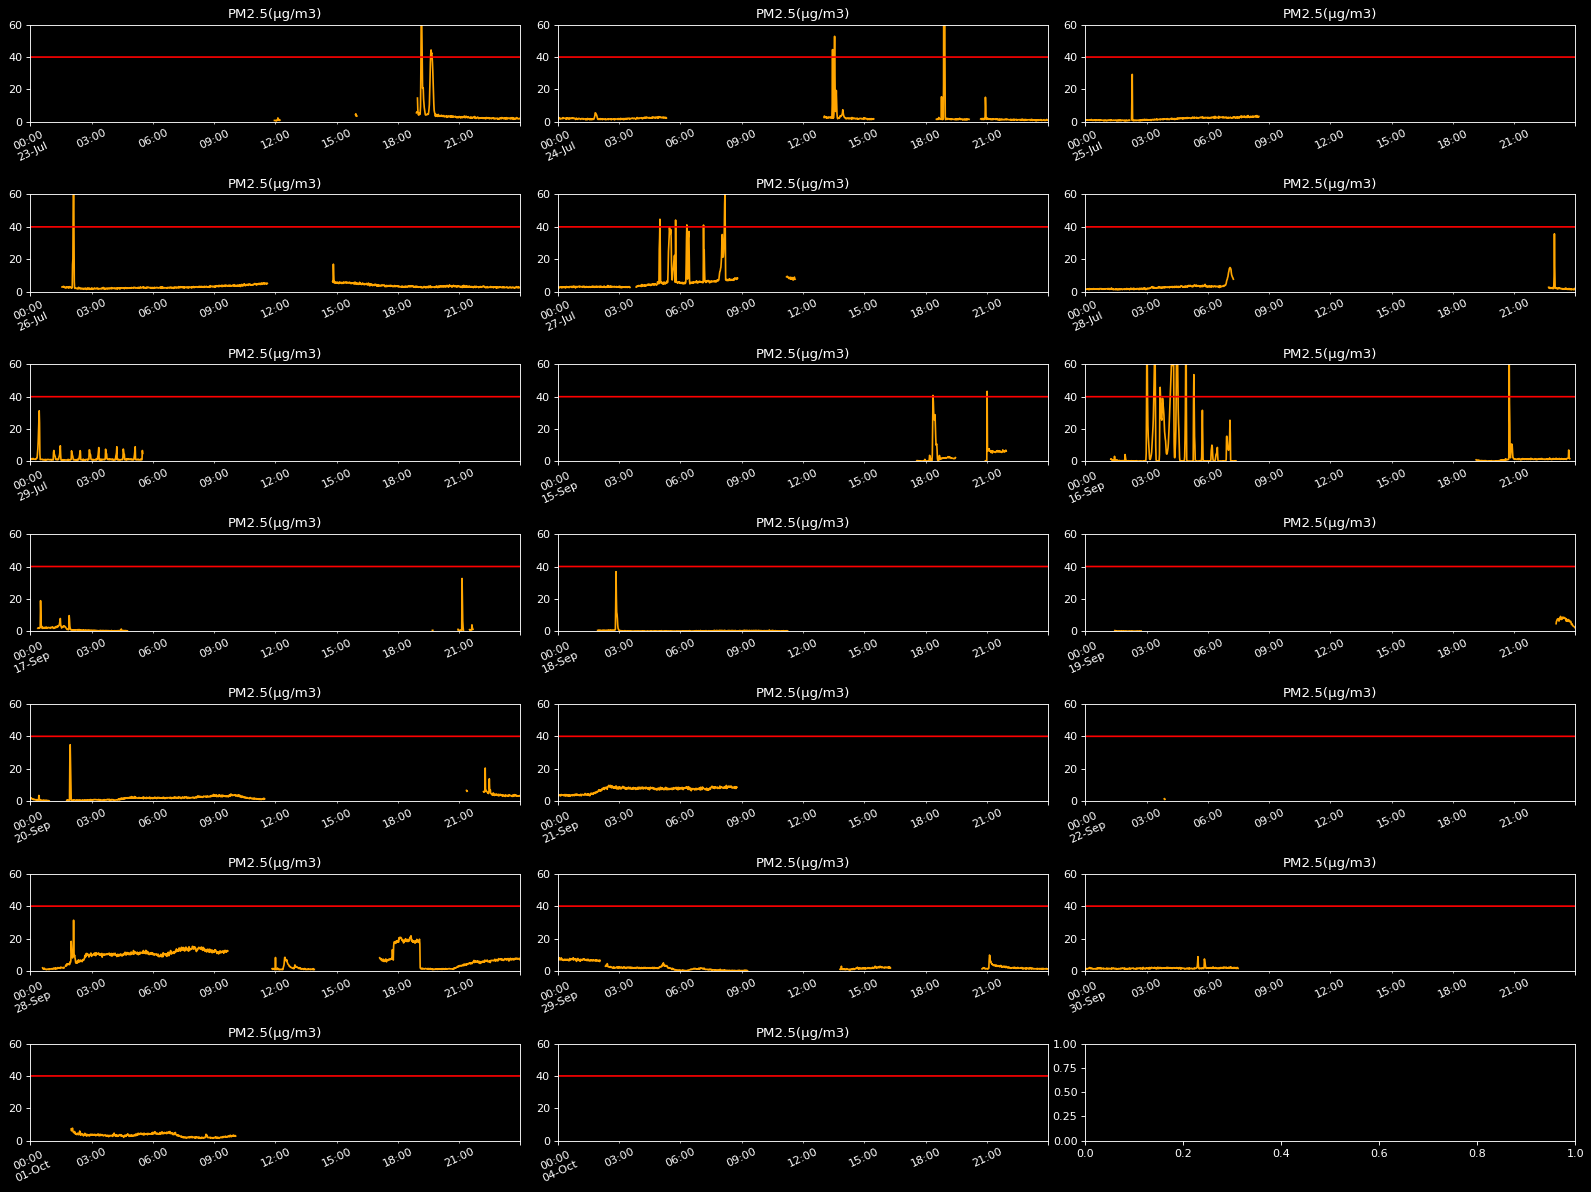

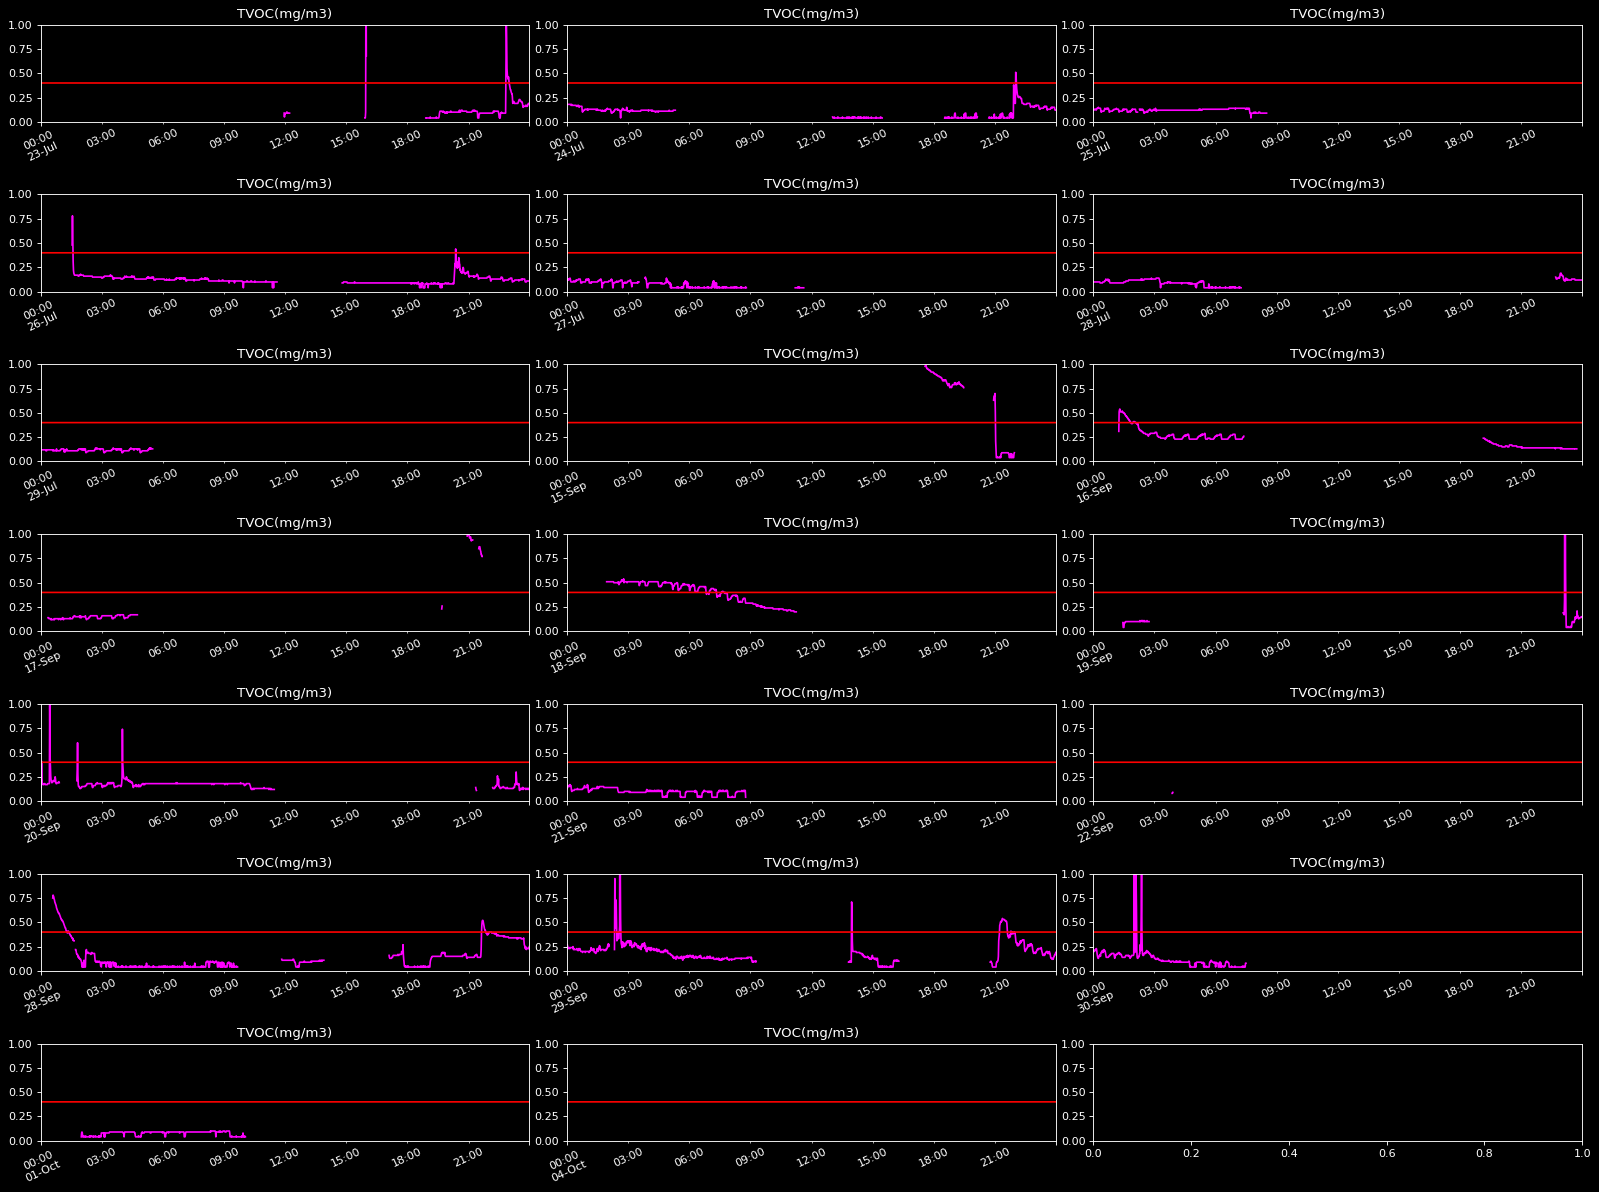

In [6]:
# plot data

plt.style.use('dark_background')

# Number of columns (plots) in each row
PLOT_N_COLUMNS = 3

def visualize_plots(dataframes, column, color, y_limit, line, line_value):
    num_plot_rows = len(dataframes)//PLOT_N_COLUMNS + 1 if len(dataframes)%PLOT_N_COLUMNS >0 else 0  
    fig, axes = plt.subplots(
        nrows= num_plot_rows, ncols=PLOT_N_COLUMNS, dpi=80, figsize=(20, 15), facecolor="w", edgecolor="k"
    )
    for i, df in enumerate(dataframes):
        # set the healthy level thresholds
        df[line] = line_value
        ax = df.plot(
            y = [column, line],
            ax=axes[i // PLOT_N_COLUMNS, i % PLOT_N_COLUMNS],
            color=color,
            title="{}".format(column),
            rot=25,
            ylim=(0, y_limit),
            legend = False,
        )
    fig.patch.set_facecolor('black')

    plt.tight_layout()
    

# generate list of dataframes, one for each csv file (one csv file per day)
dataframes = []
for file_path in file_paths:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # clean
        df = clean_df(df)
        # Append the DataFrame to the list
        dataframes.append(df)


visualize_plots(dataframes, 'PM2.5(μg/m3)', ['orange', 'red'], y_limit=60, line= 'pm_line', line_value=40)
visualize_plots(dataframes, 'TVOC(mg/m3)', ['magenta', 'red'], y_limit=1, line= 'tvoc_line', line_value=0.4)